## **Case study 2: Techno-economic comparison of hydrogen production pathways**
<p style='text-align: justify;'>Hydrogen production is a cornerstone of a low-carbon energy system, with technologies such as <b>steam methane reforming (SMR)</b>, <b>methane pyrolysis (MP)</b>, and <b>renewable-powered electrolysis</b> offering different trade-offs in efficiency, cost, and environmental impact. Their varied energy demands, carbon intensities, and capital requirements make rigorous techno-economic assessment essential for identifying scalable, cost-effective pathways.</p>

<p style='text-align: justify;'>In this case study, we apply <b>OpenPyTEA</b> to consistently evaluate the technical and economic performance of SMR, MP, and water electrolysis. The analysis covers capital and operating costs, specific energy consumption, levelized hydrogen cost, sensitivity analysis and Monte Carlo–based uncertainty analysis. This demonstrates how <b>OpenPyTEA</b> streamlines scenario setup, parameter management, and results analysis, enabling transparent and reproducible comparison across hydrogen production technologies.</p>

Let's start first by importing <b>OpenPyTEA</b>:

In [1]:
from openpytea.equipment import *
from openpytea.plant import *
from openpytea.analysis import *

To ensure a consistent comparison across all processes, we will now define the economic assumptions applied to each. Here, we assume that all processes are used to produce 50 tonnes per day of hydrogen.

In [2]:
country, region = 'United States', 'Gulf Coast'                                                 # In this case study, we take USA-Gulf Coast as an example
interest_rate, project_lifetime, plant_utilization = 0.09, 20, 0.95                             # Base project assumptions
operator_hourly_rate = 38.11                                                                    # Operator hourly rate for USA-Gulf Coast, in US$/h
h2_prod = 50_000                                                                                # Daily hydrogen production in kg (50 tonnes/day)

# utilities and raw materials prices and uncertainties
elecs_price, elecs_std, elecs_max, elecs_min =  0.10, 0.05/2, 3, 0.01                           # Price of electricity, in US$/kWh
nat_gas_price, nat_gas_std, nat_gas_max, nat_gas_min =  0.5, 0.2/2, 5, 0                        # Price of natural gas, in US$/kg
cool_water_price, cool_water_std, cool_water_max, cool_water_min = 2.4592e-4, 1e-4, 4e-4, 1e-5  # Price of cooling water, in US$/MJ
co2_tax, co2_std, co2_max, co2_min =  0.072, 0.02, 0.15, 0                                      # Price of CO2 Tax, in US$/kg CO2


The following sections present the process design and economic assessment for each hydrogen production pathway. All process parameters shown in the respective flow diagrams are derived from Aspen Plus simulations. The corresponding simulation files are provided in the folder `aspen_plus_sims`.

---------------------
### Steam Methane Reforming

<p style='text-align: justify;'>Steam methane reforming (SMR) is the most established and widely used hydrogen production technology, supplying over half of global hydrogen demand. In SMR, methane reacts with high-temperature steam over a nickel catalyst to form synthesis gas, which is then processed in a water–gas shift reactor to increase hydrogen yield. While SMR is efficient and relatively low-cost, it is also carbon-intensive due to CO₂ generated in both the reforming reaction and furnace combustion. Carbon capture can reduce emissions but adds capital and operating costs, underscoring the need for techno-economic assessment to evaluate its long-term competitiveness.</p>

![case_study_2-figure_1](img/CS_2-Fig_1.png)

**<center>Table 1.** Process equipment sizing for SMR.
<span style="font-size: 14px">

| **Equipment** | **Sizing Parameter** | **Unit** | **Equipment** | **Sizing Parameter** | **Unit** |
|---------------|-----------------------|----------|---------------|-----------------------|----------|
| Comp-1        | 945                   | kW       | SMR-REAC      | 91.56                 | kg       |
| Comp-2        | 491                   | kW       | WGS-HT-REAC   | 376.54                | kg       |
| HX-1          | 31.87                 | m²       | WGS-LT-REAC   | 3822.92               | kg       |
| HX-2          | 22.74                 | m²       | Pump          | 5.16                  | L/s      |
| HX-3          | 107.19                | m²       | PSA           | 1023.49               | kmol/h   |
| Furnace       | 33.26                 | MW       | Cooler        | 191.47                | m²       |

</span></center>

In [3]:
# First, we create the compressor and electric-motor (for driving the compressors) objects.
# We choose here the centrifugal type for both compressors.
comp_1_pwr = 945 # kW
comp_2_pwr = 491 # kW
comp_1 = Equipment('COMP-1', comp_1_pwr, "Fluids", "Compressors & blowers", "Compressor, centrifugal", "Carbon steel")
comp_2 = Equipment('COMP-2', comp_2_pwr, "Fluids", "Compressors & blowers", "Compressor, centrifugal", "Carbon steel")

# When the electric motor drives the compressors there are some losses involved. Here we assumed 90% efficiency.
mtr_eff = 0.9
mtr_1_pwr, mtr_2_pwr = comp_1_pwr / mtr_eff, comp_2_pwr / mtr_eff
mtr_1 = Equipment('MTR-1', mtr_1_pwr, "Electrical", "Motors & generators", "Totally enclosed motor", "Carbon steel")
mtr_2 = Equipment('MTR-2', mtr_2_pwr, "Electrical", "Motors & generators", "Totally enclosed motor", "Carbon steel")

# Next, we create the shell & tube heat exchanger objects.
hx_1 = Equipment('HX-1', 31.87, "Fluids", "Heat Exchangers", "U-tube shell & tube", '304 stainless steel')
hx_2 = Equipment('HX-2', 22.74, "Fluids", "Heat Exchangers", "U-tube shell & tube", '304 stainless steel')
hx_3 = Equipment('HX-3', 107.19, "Fluids", "Heat Exchangers", "U-tube shell & tube", '304 stainless steel')
cooler = Equipment('COOLER', 191.47, "Fluids", "Heat Exchangers", "U-tube shell & tube", 'Carbon steel')

# MAYBE ADD A COOLER FOR FAIR COMPARISON WITH MP?

# Now we create the reactor, furnace, cyclone and PSA objects.
smr_reactor = Equipment('SMR-REACTOR', 120, "Fluids", "Pressure vessels", "Vertical 304SS")
wgs_ht_reactor = Equipment('WGS-HT-REACTOR', 376.54, "Fluids", "Pressure vessels", "Vertical 304SS")
wgs_lt_reactor = Equipment('WGS-LT-REACTOR', 3822.92, "Fluids", "Pressure vessels", "Vertical 304SS")

furnace = Equipment('FURNACE', 33.26, "Fluids", "Boilers & furnaces", "Furnace, cylindrical", "304 stainless steel")
pump = Equipment('PUMP', 5.16, "Fluids", "Pumps", "Single-stage centrifugal pump", "Carbon steel")
psa = Equipment('PSA', 1023.49, "Fluids", "Gas separation", "Pressure-swing adsorber", "Carbon steel")

# We can now create a list of the equipment for the SMR process.
smr_equipment = [
    comp_1, mtr_1,
    comp_2, mtr_2,
    hx_1, hx_2, hx_3,
    cooler,
    smr_reactor, 
    wgs_ht_reactor, wgs_lt_reactor,
    furnace, pump, psa
]

In [4]:
# Configuration for the SMR best case
config = {'plant_name': 'Steam Methane Reforming',
          'process_type': 'Mixed',   # Since there are both fluids and solids involved, we choose 'Mixed'
          'country': country, 'region': region,
          'equipment': smr_equipment, # This the list of equipment for the SMR process
          'variable_opex_inputs': {  # For the variable opex inputs, the consumption is always best on daily consumption
              'electricity': {
                  'consumption': (mtr_1_pwr + mtr_2_pwr)*24, 'price': elecs_price, 'price_std': elecs_std, 'price_max': elecs_max, 'price_min': elecs_min
              },
              'methane_feed':{ # We assume the methane feed is natural gas. They are use as the main feedstock for the process as well as heating fuel
                  'consumption': (5139+4025)*24, 'price': nat_gas_price, 'price_std': nat_gas_std, 'price_max': nat_gas_max, 'price_min': nat_gas_min
              },
              'cooling_water': { # Cooling duties in Cooler-1, Cooler-2 and Comp-2 intercoolers (the value comes from the Aspen Plus simulation)
                  'consumption': (20222.67)*24, 'price': cool_water_price, 'price_std': cool_water_std, 'price_max': cool_water_max, 'price_min': cool_water_min
              },
              'co2_tax': {
                  'consumption': 25124.64*24, 'price': co2_tax, 'price_std': co2_std, 'price_max': co2_max, 'price_min': co2_min
              },
            },
            'interest_rate': interest_rate, 'operator_hourly_rate': operator_hourly_rate, 'project_lifetime': project_lifetime, # Base economic assumptions
            'plant_utilization': plant_utilization, 'daily_prod': h2_prod # Daily hydrogen production in kg
}
smr_plant = Plant(config)  # Create the process plant object. Here we name it smr_plant.

In [5]:
smr_plant.calculate_fixed_capital(print_results=True)  # Calculate the LCOH and print the details
smr_plant.calculate_variable_opex(print_results=True)  # Calculate the LCOH and print the details
smr_plant.calculate_levelized_cost(print_results=True)  # Calculate the LCOH and print the details

Capital cost estimation
ISBL: $29,423,015.97
OSBL: $11,769,206.39
Design and engineering: $10,298,055.59
Contingency: $4,119,222.24
Fixed capital investment: $55,609,500.19
Variable production costs estimation
  - Electricity: $1,327,821.33 per year
  - Methane feed: $38,131,404.00 per year
  - Cooling water: $41,386.63 per year
  - Co2 tax: $15,054,282.29 per year
Total Variable OPEX: $54,554,894.26 per year
Levelized cost: $4.526/kg


In [6]:
monte_carlo(smr_plant, num_samples=1_000_000, batch_size=1000, show_final_plot=False)

Running Monte Carlo: 100%|██████████| 1000/1000 [01:31<00:00, 10.91it/s]


---------------

### Methane Pyrolysis (MP)
<p style='text-align: justify;'>Methane pyrolysis produces hydrogen without direct CO₂ emissions by thermally splitting methane into hydrogen and solid carbon. Depending on the heat source—such as plasma, molten metal, or non-catalytic reactors—the process exhibits different efficiencies and scale-up challenges. When powered by renewable or waste heat, methane pyrolysis offers a low-carbon hydrogen pathway, though its economics depend heavily on reactor design, heat supply, and the management or valorization of the solid carbon by-product.</p>

<p style='text-align: justify;'>This case study follows the non-catalytic methane pyrolysis process of Keipi et al. (2018), using a regenerative heat-exchanger reactor (RHER). Methane is cracked at 1300 K, producing hydrogen while depositing solid carbon. In addition to external heating, hot product gases heat a circulating bed of ceramic beads, which in turn preheat the incoming methane. Most carbon forms on the bead surfaces and is removed through the circulation loop. For simplicity, detailed modeling of the bed-material loop and downstream carbon-handling units is omitted.</p>

<p style='text-align: justify;'>The following figure presents the MP process flow diagram, and the accompanying table summarizes the equipment sizing:</p>

![case_study_2-figure_2](img/CS_2-Fig_2.png)
**<p style='text-align: justify;'>Figure 2.** Process flow diagram of a methane pyrolysis system producing hydrogen and solid carbon. Fresh methane feed is compressed (COMP-1) and preheated in heat exchanger (HX-1) before entering the moving bed reactor, where endothermic pyrolysis occurs and using a heated bed material circulated to separate the gas-solid products. Combustion of a CH₄–air stream (COMP-3) supplies the thermal energy, and the resulting flue gas exits the system. Carbon particulates are separated in a cyclone and routed to a dedicated carbon-bed material separation unit for solid carbon recovery. The gas products from the reactor is cooled (COOLER-1, COOLER-2), compressed (COMP-2), and purified in a Pressure Swing Adsorption (PSA) unit to produce a hydrogen stream, while unreacted methane is recycled to the reactor.</p>


**<center>Table 2.** Process equipment sizing for MP.
<span style="font-size: 14px">

| **Equipment** | **Sizing Parameter** | **Unit** | **Equipment** | **Sizing Parameter** | **Unit** |
|---------------|-----------------------|----------|---------------|-----------------------|----------|
| Comp-1        | 205                   | kW       | HX-1          | 28.37                 | m²       |
| Comp-2        | 2993                  | kW       | COOLER-1      | 41.85                 | m²       |
| Comp-3        | 363                   | kW       | COOLER-2      | 26.21                 | m²       |
| Reactor       | 147.26                | m³       | Cyclone       | 36.70                 | m³/s     |
| Furnace       | 22608                 | kW       | PSA           | 1017.98               | kmol/h   |

</span></center>

Now, let's create the equipment objects:

In [7]:
# First, we create the compressor and electric-motor (for driving the compressors) objects.
# We choose here the centrifugal type for both compressors.
comp_1_pwr = 205 # kW
comp_2_pwr = 2993 # kW
comp_3_pwr = 363 # kW
comp_1 = Equipment('COMP-1', comp_1_pwr, "Fluids", "Compressors & blowers", "Compressor, centrifugal", "Carbon steel")
comp_2 = Equipment('COMP-2', comp_2_pwr, "Fluids", "Compressors & blowers", "Compressor, centrifugal", "Carbon steel")
comp_3 = Equipment('COMP-3', comp_3_pwr, "Fluids", "Compressors & blowers", "Compressor, centrifugal", "Carbon steel")

# When the electric motor drives the compressors there are some losses involved. Here we assumed 90% efficiency.
mtr_eff = 0.9
mtr_1_pwr, mtr_2_pwr, mtr_3_pwr = comp_1_pwr / mtr_eff, comp_2_pwr / mtr_eff, comp_3_pwr / mtr_eff
mtr_1 = Equipment('MTR-1', mtr_1_pwr, "Electrical", "Motors & generators", "Totally enclosed motor", "Carbon steel")
mtr_2 = Equipment('MTR-2', mtr_2_pwr, "Electrical", "Motors & generators", "Totally enclosed motor", "Carbon steel")
mtr_3 = Equipment('MTR-3', mtr_3_pwr, "Electrical", "Motors & generators", "Totally enclosed motor", "Carbon steel")

# Next, we create the shell & tube heat exchanger objects.
hx_1 = Equipment('HX-1', 28.37, "Fluids", "Heat Exchangers", "U-tube shell & tube", '316 stainless steel')
cooler_1 = Equipment('COOLER-1', 41.85, "Fluids", "Heat Exchangers", "U-tube shell & tube", 'Carbon steel')
cooler_2 = Equipment('COOLER-2', 26.21, "Fluids", "Heat Exchangers", "U-tube shell & tube", 'Carbon steel')

# Now we create the reactor, furnace, cyclone and PSA objects.
reactor = Equipment('REACTOR', 147.26, "Mixed", "Reactors", "Indirect fluidized-bed", "316 stainless steel")
furnace = Equipment('FURNACE', 22608, "Fluids", "Boilers & furnaces", "Pyrolysis furnace", "316 stainless steel")
cyclone = Equipment('CYCLONE', 36.70, "Mixed", "Cyclones", "Gas multi-cyclone", "316 stainless steel")
psa = Equipment('PSA', 1017.98, "Fluids", "Gas separation", "Pressure-swing adsorber", "Carbon steel")

# We can now create a list of the equipment for the SMR process.
mp_equipment = [
    comp_1, mtr_1,
    comp_2, mtr_2,
    comp_3, mtr_3,
    hx_1, cooler_1, cooler_2,
    reactor, furnace,
    cyclone, psa
]

Now we make the methane pyrolysis plant object:

In [8]:
# Configuration for the SMR best case
config = {'plant_name': 'Methane Pyrolysis',
          'process_type': 'Mixed',   # Since there are both fluids and solids involved, we choose 'Mixed'
          'country': country, 'region': region,
          'equipment': mp_equipment, # This the list of equipment for the MP process
          'variable_opex_inputs': {  # For the variable opex inputs, the consumption is always best on daily consumption
              'electricity': {
                  'consumption': (mtr_1_pwr + mtr_2_pwr + mtr_3_pwr)*24, 'price': elecs_price, 'price_std': elecs_std, 'price_max': elecs_max, 'price_min': elecs_min
              },
              'methane_feed':{ # We assume the methane feed is natural gas. They are use as the main feedstock for the process as well as heating fuel
                  'consumption': (8184+3775)*24, 'price': nat_gas_price, 'price_std': nat_gas_std, 'price_max': nat_gas_max, 'price_min': nat_gas_min
              },
              'cooling_water': { # Cooling duties in Cooler-1, Cooler-2 and Comp-2 intercoolers (the value comes from the Aspen Plus simulation)
                  'consumption': (12816.41+1313.09+9443.57)*24, 'price': cool_water_price, 'price_std': cool_water_std, 'price_max': cool_water_max, 'price_min': cool_water_min
              },
              'co2_tax': {
                  'consumption': 10357*24, 'price': co2_tax, 'price_std': co2_std, 'price_max': co2_max, 'price_min': co2_min
              },
              # Methane pyrolysis produces solid carbon. Part of this carbon may be sold as a byproduct (if quality/demand allows),
              #  while the remaining portion must be disposed of at a cost. 
              'carbon_byproduct_sale': { # we assumed that 50% of the produced carbon can be sold (hence, the minus sign in consumption)
                  'consumption': -6100*0.5*24, 'price': 1, 'price_std': 0.5/2, 'price_max': 3, 'price_min': 0
              },
              'carbon_disposal_fee': { # the remaining 50% must be disposed of at a cost
                  'consumption': 6100*0.5*24, 'price': 0.5, 'price_std': 0.5/2, 'price_max': 1, 'price_min': 0
              }
            },
            'interest_rate': interest_rate, 'operator_hourly_rate': operator_hourly_rate, 'project_lifetime': project_lifetime, # Base economic assumptions
            'plant_utilization': plant_utilization, 'daily_prod': h2_prod # Daily hydrogen production in kg
}
mp_plant = Plant(config)  # Create the process plant object. Here we name it mp_plant.

In [9]:
mp_plant.calculate_fixed_capital(print_results=True)  # Calculate the LCOH and print the details
mp_plant.calculate_variable_opex(print_results=True)  # Calculate the LCOH and print the details
mp_plant.calculate_levelized_cost(print_results=True)  # Calculate the LCOH and print the details

Capital cost estimation
ISBL: $40,303,128.07
OSBL: $16,121,251.23
Design and engineering: $14,106,094.83
Contingency: $5,642,437.93
Fixed capital investment: $76,172,912.06
Variable production costs estimation
  - Electricity: $3,292,738.00 per year
  - Methane feed: $49,761,399.00 per year
  - Cooling water: $48,243.38 per year
  - Co2 tax: $6,205,748.69 per year
  - Carbon byproduct sale: $-25,382,100.00 per year
  - Carbon disposal fee: $12,691,050.00 per year
Total Variable OPEX: $46,617,079.07 per year
Levelized cost: $5.089/kg


In [10]:
monte_carlo(mp_plant, num_samples=1_000_000, batch_size=1000, show_final_plot=False)

Running Monte Carlo: 100%|██████████| 1000/1000 [01:17<00:00, 12.97it/s]


-------------------------------
### Water Electrolysis
<p style='text-align: justify;'>Water electrolysis produces hydrogen by splitting water into hydrogen and oxygen using electricity. Alkaline, PEM, and solid oxide electrolyzers vary in efficiency, operational flexibility, and capital cost, but all can deliver zero on-site emissions when powered by renewable electricity. Although widely viewed as a cornerstone of green hydrogen production, the economics of electrolysis remain highly sensitive to electricity price, capacity factor, and stack replacement costs. As renewable power becomes cheaper and more abundant, rigorous techno-economic assessment is essential for understanding the future role of electrolysis in low-carbon energy systems.</p>

----------------------------------

### Techno-economic comparison

In [11]:
# tornado_plot(smr_plant, 0.5, r'Levelized cost of product / [US\$$\cdot$kg$^{-1}$]')

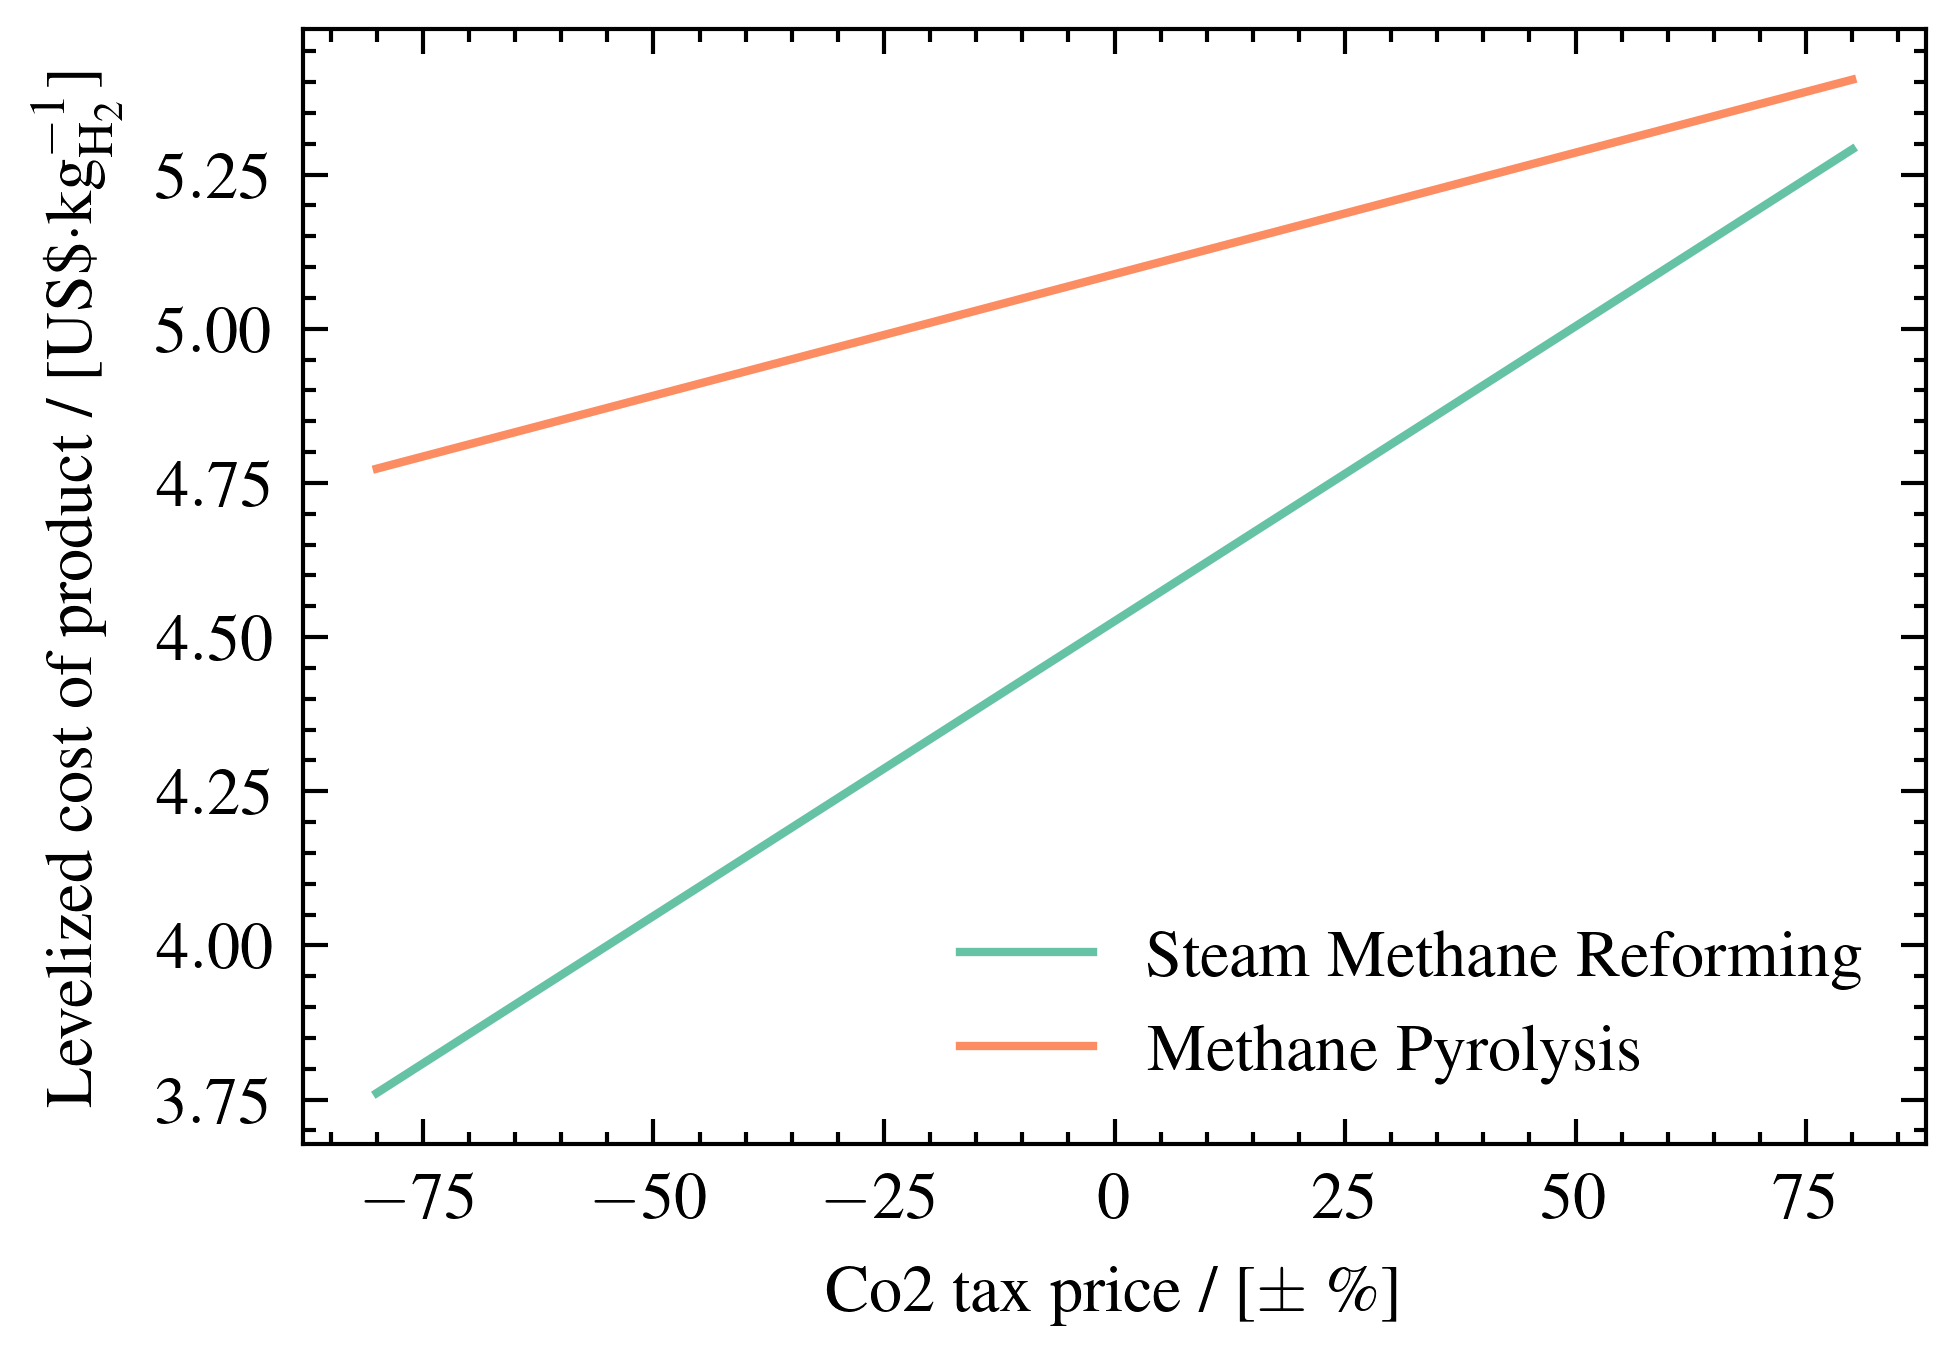

In [12]:
sensitivity_plot([smr_plant, mp_plant], 'co2_tax', 0.8)

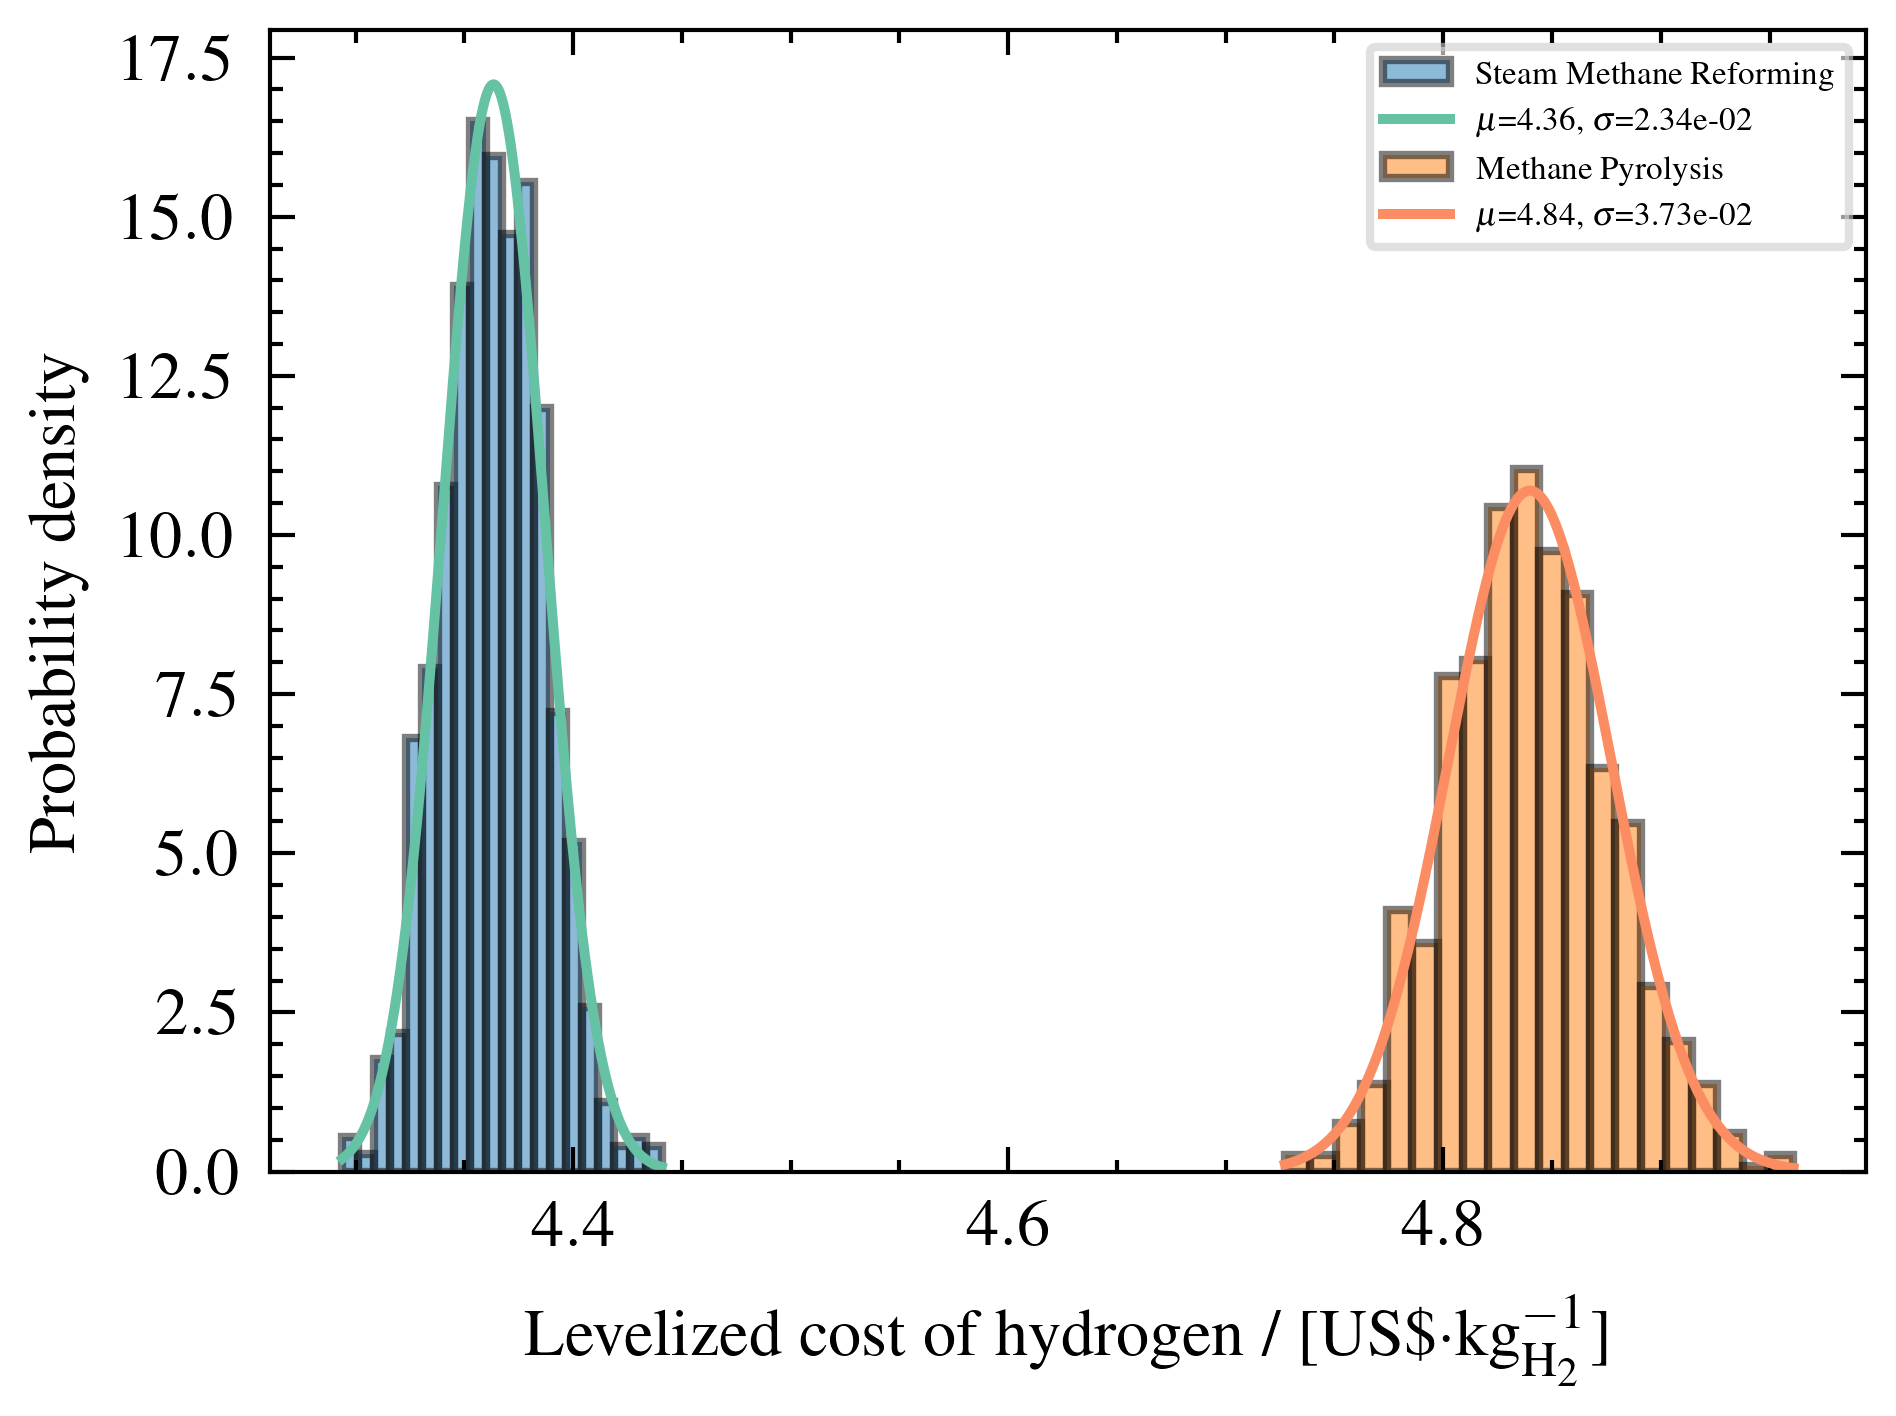

In [13]:
plot_multiple_monte_carlo([smr_plant, mp_plant], bins=20, label=r'Levelized cost of hydrogen / [US\$$\cdot$kg$^{-1}_\mathrm{H_2}$]')